In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from faker import Faker
fake = Faker()
from random import randint, choices
from customer import Customer

In [2]:
def addcheckout(df): # added missing checkout entries
    last = df.groupby(['customer_no']).last()
    last.drop(last[last['location'] == 'checkout'].index,inplace=True)
    last.drop(columns={'location'},inplace=True)
    last.reset_index(inplace=True)
    
    tobeadded = []
    for i in last['customer_no'] :
        oneentry = [i,F'{df.index[-1].year}-{df.index[-1].month}-{df.index[-1].day} 21:51:00','checkout',df.day[-1]]
        tobeadded.append(oneentry)
    
    
    dfadd = pd.DataFrame(tobeadded, columns = ['customer_no','timestamp','location','day'])
    dfadd = dfadd.set_index(['timestamp'])
    dfadd.index = pd.to_datetime(dfadd.index)
    
    appendedDF = df.append(dfadd)
    
    return(appendedDF)

In [3]:
def dayname(dayframe): # adds a column with a weekday
    value = dayframe.index[-1].dayofweek
    if value == 0:
        dayframe['day'] = 'mon'
    elif value == 1:
        dayframe['day'] = 'tue'
    elif value == 2:
        dayframe['day'] = 'wed'
    elif value == 3:
        dayframe['day'] = 'thu'
    elif value == 4:
        dayframe['day'] = 'fri'
    elif value == 5:
        dayframe['day'] = 'sat'
    elif value == 6:
        dayframe['day'] = 'sun'
    else:
        print('something is wrong!!')
    return(dayframe)

In [4]:
def fill(day): # fills missing timestamps
    day = day.groupby(['customer_no']).resample('min').ffill()
    return(day)

In [5]:
def combinedays(Frames): #takes a List of DataFrames
    newdf = pd.DataFrame()
    last = 0
    for i in Frames:
        i.customer_no = i.customer_no + last
        last = i.customer_no.max()
        newdf = newdf.append(i)
    return(newdf)

In [6]:
dfmon = pd.read_csv('data/monday.csv', delimiter = ';',parse_dates = True,index_col = 'timestamp')
dftue = pd.read_csv('data/tuesday.csv', delimiter = ';',parse_dates = True,index_col = 'timestamp')
dfwed = pd.read_csv('data/wednesday.csv', delimiter = ';',parse_dates = True,index_col = 'timestamp')
dfthu = pd.read_csv('data/thursday.csv', delimiter = ';',parse_dates = True,index_col = 'timestamp')
dffri = pd.read_csv('data/friday.csv', delimiter = ';',parse_dates = True,index_col = 'timestamp')

In [7]:
weekdays = [dfmon,dftue,dfwed,dfthu,dffri]

In [8]:
dayweek = []
for a in weekdays:
    dayweek.append(dayname(a))
weekdays = dayweek

In [9]:
newweekdays = []
for i in weekdays:
    newweekdays.append(addcheckout(i))

In [10]:
filledday =[]
for d in newweekdays:
    filledday.append(fill(d))

In [14]:
notfilled = combinedays(newweekdays)
notfilled.reset_index(inplace=True)
notfilled.head(8)

,timestamp,customer_no,location,day
0,2019-09-02 07:03:00,1,dairy,mon
1,2019-09-02 07:03:00,2,dairy,mon
2,2019-09-02 07:04:00,3,dairy,mon
3,2019-09-02 07:04:00,4,dairy,mon
4,2019-09-02 07:04:00,5,spices,mon
5,2019-09-02 07:04:00,6,spices,mon
6,2019-09-02 07:04:00,7,spices,mon
7,2019-09-02 07:04:00,8,fruit,mon


In [30]:
combiweek = combinedays(filledday)
combiweek.head(8)

customer_no  location  day
customer_no timestamp                                      
1           2019-09-02 07:03:00            1     dairy  mon
            2019-09-02 07:04:00            1     dairy  mon
            2019-09-02 07:05:00            1  checkout  mon
2           2019-09-02 07:03:00            2     dairy  mon
            2019-09-02 07:04:00            2     dairy  mon
            2019-09-02 07:05:00            2     dairy  mon
            2019-09-02 07:06:00            2  checkout  mon
3           2019-09-02 07:04:00            3     dairy  mon

In [31]:
combiweek.rename(columns={'customer_no': 'number'},inplace=True)
combiweek.reset_index(inplace=True)
combiweek.drop(['customer_no'],axis=1,inplace=True)
combiweek.head(8)

,timestamp,number,location,day
0,2019-09-02 07:03:00,1,dairy,mon
1,2019-09-02 07:04:00,1,dairy,mon
2,2019-09-02 07:05:00,1,checkout,mon
3,2019-09-02 07:03:00,2,dairy,mon
4,2019-09-02 07:04:00,2,dairy,mon
5,2019-09-02 07:05:00,2,dairy,mon
6,2019-09-02 07:06:00,2,checkout,mon
7,2019-09-02 07:04:00,3,dairy,mon


In [18]:
#Calculate the total number of customers in each section
notfilled.groupby(['location','day'])['customer_no'].count()

location  day
checkout  fri    1510
          mon    1447
          thu    1535
          tue    1422
          wed    1531
dairy     fri     932
          mon     895
          thu     965
          tue     911
          wed     976
drinks    fri     844
          mon     797
          thu     776
          tue     713
          wed     775
fruit     fri    1057
          mon    1005
          thu    1041
          tue     976
          wed    1043
spices    fri     790
          mon     750
          thu     790
          tue     694
          wed     730
Name: customer_no, dtype: int64

In [19]:
#Calculate the total number of customers in each section over time
loc_time = combiweek.groupby(['day','location','timestamp'])['number'].count()

loc_time

day  location  timestamp          
fri  checkout  2019-09-06 07:01:00    1
               2019-09-06 07:02:00    1
               2019-09-06 07:04:00    1
               2019-09-06 07:05:00    2
               2019-09-06 07:09:00    1
                                     ..
wed  spices    2019-09-04 21:46:00    1
               2019-09-04 21:47:00    1
               2019-09-04 21:48:00    3
               2019-09-04 21:49:00    1
               2019-09-04 21:50:00    1
Name: number, Length: 18770, dtype: int64

In [20]:
#Display the number of customers at checkout over time
loc_time['mon','checkout']

timestamp
2019-09-02 07:05:00     2
2019-09-02 07:06:00     2
2019-09-02 07:07:00     1
2019-09-02 07:08:00     3
2019-09-02 07:09:00     1
                       ..
2019-09-02 21:46:00     1
2019-09-02 21:47:00     2
2019-09-02 21:48:00     2
2019-09-02 21:49:00     2
2019-09-02 21:51:00    10
Name: number, Length: 701, dtype: int64

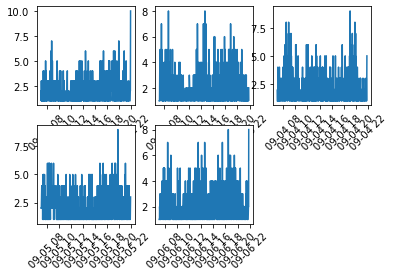

In [21]:
#Display the number of customers at checkout over time


plt.subplot(2,3,1)
plt.xticks(rotation = 45)
plt.plot(loc_time['mon','checkout'][:])
plt.subplot(2,3,2)
plt.xticks(rotation = 45)
plt.plot(loc_time['tue','checkout'][:])
plt.subplot(2,3,3)
plt.xticks(rotation = 45)
plt.plot(loc_time['wed','checkout'][:])
plt.subplot(2,3,4)
plt.xticks(rotation = 45)
plt.plot(loc_time['thu','checkout'][:])
plt.subplot(2,3,5)
plt.xticks(rotation = 45)
plt.plot(loc_time['fri','checkout'][:])

In [22]:
#Calculate the total number of customers in the supermarket over time.

dfmoncounts = combiweek.groupby(['day','timestamp'],sort=False)['number'].count()

(array([-1000.,     0.,  1000.,  2000.,  3000.,  4000.,  5000.]),
 [Text(-1000.0, 0, '(thu, 2019-09-05 20:04:00)'),
  Text(0.0, 0, '(mon, 2019-09-02 07:03:00)'),
  Text(1000.0, 0, '(tue, 2019-09-03 08:53:00)'),
  Text(2000.0, 0, '(wed, 2019-09-04 10:41:00)'),
  Text(3000.0, 0, '(thu, 2019-09-05 12:30:00)'),
  Text(4000.0, 0, '(fri, 2019-09-06 14:18:00)'),
  Text(5000.0, 0, '')])

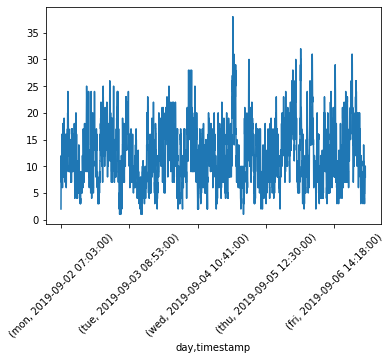

In [23]:
dfmoncounts.plot()
plt.xticks(rotation = 45)

In [24]:
#Calculate the time each customer spent in the market
start = combiweek.groupby(['number']).nth([0])['timestamp']
end = combiweek.groupby(['number']).last()['timestamp']
time = end - start
print(f'Customer time in supermarket \n median = {time.median()} \n mean = {time.mean()} \n longest stay = {time.max()}')

Customer time in supermarket 
 median = 0 days 00:04:00 
 mean = 0 days 00:06:14.933512424 
 longest stay = 0 days 00:52:00


In [25]:
#Calculate the time each customer spent in the market
startn = notfilled.groupby(['customer_no']).nth([0])['timestamp']
endn = notfilled.groupby(['customer_no']).last()['timestamp']
timenotfilled = endn - startn
print(f'Customer time in supermarket \n median = {timenotfilled.median()} \n mean = {timenotfilled.mean()} \n longest stay = {timenotfilled.max()}')

Customer time in supermarket 
 median = 0 days 00:04:00 
 mean = 0 days 00:06:14.933512424 
 longest stay = 0 days 00:52:00


# *** transition ***

In [32]:
combiweek['transition'] = combiweek['location'].shift(-1)

In [33]:
combiweek.tail(6)

,timestamp,number,location,day,transition
53962,2019-09-06 21:49:00,102043,dairy,fri,checkout
53963,2019-09-06 21:50:00,102043,checkout,fri,drinks
53964,2019-09-06 21:50:00,102044,drinks,fri,checkout
53965,2019-09-06 21:51:00,102044,checkout,fri,spices
53966,2019-09-06 21:50:00,102045,spices,fri,checkout
53967,2019-09-06 21:51:00,102045,checkout,fri,NaN


In [34]:
combiweek.loc[combiweek['location'] == 'checkout' , 'transition'] = 'checkout'

In [35]:
combiweek.tail(6)

,timestamp,number,location,day,transition
53962,2019-09-06 21:49:00,102043,dairy,fri,checkout
53963,2019-09-06 21:50:00,102043,checkout,fri,checkout
53964,2019-09-06 21:50:00,102044,drinks,fri,checkout
53965,2019-09-06 21:51:00,102044,checkout,fri,checkout
53966,2019-09-06 21:50:00,102045,spices,fri,checkout
53967,2019-09-06 21:51:00,102045,checkout,fri,checkout


In [37]:
#pd.crosstab(df['after'], df['before'], normalize=0)
Transitionsprobabilities = pd.crosstab(combiweek['location'], combiweek['transition'], normalize=0)
Transitionsprobabilities

transition,checkout,dairy,drinks,fruit,spices
location,,,,,
checkout,1.000000,0.000000,0.000000,0.000000,0.000000
dairy,0.103344,0.737061,0.058500,0.049789,0.051307
drinks,0.215688,0.010898,0.598540,0.087900,0.086974
fruit,0.201447,0.095848,0.054804,0.597264,0.050637
spices,0.150565,0.193061,0.162979,0.090880,0.402515


In [38]:

combiweek.groupby(['number']).first()['location'].count()

7445

In [39]:
firsts = combiweek.groupby(['number']).first()['location'].values
firsts[0:6]

array(['dairy', 'dairy', 'dairy', 'dairy', 'spices', 'spices'],
      dtype=object)

In [40]:
dairy = 0
drinks = 0
fruit = 0
spices = 0
x = 0

for item in firsts :
    #print(item)
    x = x + 1
    if item == 'dairy':
        dairy = dairy + 1
        
    elif item == 'drinks':
        drinks = drinks + 1
        
    elif item == 'fruit':
        fruit = fruit + 1
        
    elif item == 'spices':
        spices = spices + 1
    else:
        print('something went wrong!!')

print(x , dairy , drinks , fruit, spices)
startprobability_dict = {'dairy': dairy/x , 'drinks': drinks/x , 'fruit': fruit/x, 'spices': spices/x}
startprobabilities = pd.DataFrame([startprobability_dict])
startprobabilities

7445 2141 1143 2810 1351


,dairy,drinks,fruit,spices
0,0.287576,0.153526,0.377435,0.181464


<AxesSubplot:>

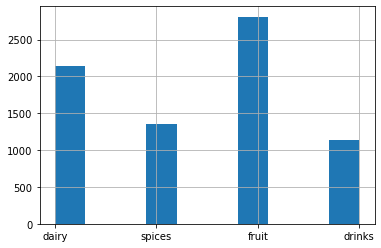

In [41]:
# the first section customers visit
combiweek.groupby(['number']).first()['location'].hist()

In [42]:
maxsmin = combiweek.groupby(['number'])['timestamp'].count().max()
maxsmin

53

<AxesSubplot:>

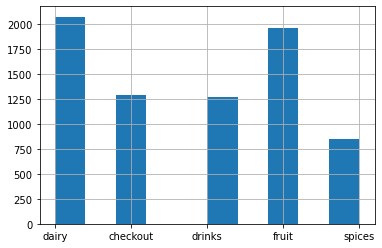

In [43]:
# after first minute section customers visit
combiweek.groupby(['number']).nth([1,maxsmin])['location'].hist()

In [44]:
transitions = notfilled.groupby(['customer_no'])['timestamp'].count().max()

<AxesSubplot:>

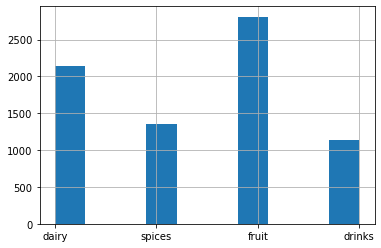

In [45]:
# the first section customers visit
notfilled.groupby(['customer_no']).first()['location'].hist()

<AxesSubplot:>

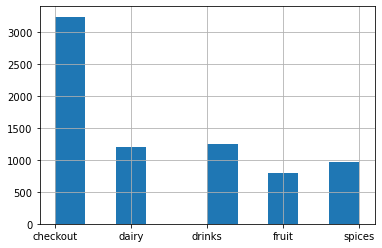

In [46]:
# following sections customers visit
notfilled.groupby(['customer_no']).nth([1,transitions])['location'].hist()

In [47]:
states = ['dairy', 'drinks', 'fruit', 'spices']
statesin = ['checkout','dairy', 'drinks', 'fruit', 'spices']

In [48]:
staproo = startprobabilities.to_numpy()
stapro = staproo[0]
print(stapro)

[0.28757555 0.15352586 0.37743452 0.18146407]


In [49]:
customerlist = []
for i in range(1,5):
    state = choices(states, stapro)[0]
    money = randint(10, 100)
    name = fake.name()
    tempcust = Customer(id=i,name =name ,state = state,budget= money)
    customerlist.append(tempcust)
customerlist
                        

[ID:1 Brent Lang is at dairy with a budget of 26,
 ID:2 Erika Montoya is at spices with a budget of 69,
 ID:3 George Macias is at fruit with a budget of 87,
 ID:4 Ryan Hardy is at dairy with a budget of 53]

In [50]:
trans_prob = Transitionsprobabilities.T.to_dict()
probsformcmc = {'checkout': list(trans_prob['checkout'].values()),
                'dairy' : list(trans_prob['dairy'].values()),
                'drinks' : list(trans_prob['drinks'].values()),
                'fruit' : list(trans_prob['fruit'].values()),
                'spices' : list(trans_prob['spices'].values())
               }
                

In [51]:
def markov_chain_super(customer , transprob, states):
    minutes = 0
    visits = [customer.state]
    state = customer.state
    while True:
        #print(state)
        probs = transprob[state]
        #print(probs)
        state = choices(states, probs)[0]
        #print(state)
        visits.append((state))
        minutes = minutes + 1
        if state == 'checkout':
            print(f'{customer.name} stayed for {minutes} minutes.')
            return print(f'and visited {visits}')

In [52]:
for customer in customerlist:
    markov_chain_super(customer , probsformcmc, statesin)

Brent Lang stayed for 1 minutes.
and visited ['dairy', 'checkout']
Erika Montoya stayed for 12 minutes.
and visited ['spices', 'spices', 'fruit', 'spices', 'spices', 'dairy', 'dairy', 'dairy', 'dairy', 'dairy', 'spices', 'spices', 'checkout']
George Macias stayed for 1 minutes.
and visited ['fruit', 'checkout']
Ryan Hardy stayed for 14 minutes.
and visited ['dairy', 'dairy', 'dairy', 'dairy', 'dairy', 'dairy', 'dairy', 'dairy', 'dairy', 'dairy', 'dairy', 'dairy', 'dairy', 'drinks', 'checkout']


In [ ]:
liste1 = markov_chain_super(cust01 , probsformcmc, statesin)
print(liste1)
liste2 = markov_chain_super(cust02 , probsformcmc, statesin)
print(liste2)

In [ ]:
state = cust01.state[0]
state